In [1]:
import sys
import pathlib
import pickle

_path = str(pathlib.Path("../scripts/").absolute())
if _path not in sys.path:
    sys.path.append(_path)
    # sys.path.append("/mnt/home/apricewhelan/downloads/Agama-zone/")

from astropy.constants import G
import astropy.table as at
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
import gala.integrate as gi
import jax
import jaxopt
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
from gala.units import galactic
from scipy.interpolate import InterpolatedUnivariateSpline
from tqdm import trange
from pyia import GaiaData

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import torusimaging as oti
from torusimaging_helpers.config import gala_pot, agama_pot, R0, vc0, galcen_frame

from torusimaging_helpers.plot import (
    plot_bdata,
    plot_data_model_residual,
    plot_spline_functions,
    plot_az_Jz,
    plot_orbit_shapes,
)

import agama

agama.setUnits(mass=u.Msun, length=u.kpc, time=u.Myr)

In [2]:
# Made in: Figure-observed-vertical-gradients.ipynb
tbl = at.QTable.read("../data/apogee-rgb-sample.fits")
for col in tbl.colnames:
    if tbl[col].dtype.char in np.typecodes["AllFloat"]:
        tbl[col] = tbl[col].astype(np.float64)
g = GaiaData(tbl)

In [3]:
mask_bits = {
    "ASPCAPFLAG": [7, 23],  # STAR_WARN, STAR_BAD
    "STARFLAG": [9, 18, 16, 17, 23],  # PERSIST_HIGH, BAD_RV_COMBINATION, etc.
    # Remove stars targeted in known clusters or dwarf galaxies:
    "APOGEE_TARGET1": [9, 18, 24, 26],
    "APOGEE_TARGET2": [10, 18],
    "APOGEE2_TARGET1": [9, 18, 20, 21, 22, 23, 24, 26],
    "APOGEE2_TARGET2": [10],
    "APOGEE2_TARGET3": [5, 14, 15],
    "MEMBERFLAG": 0,
}

target_mask = np.ones(len(g), dtype=bool)
for name, bits in mask_bits.items():
    if isinstance(bits, (list, np.ndarray)):
        target_mask &= (g[name] & np.sum(2 ** np.array(bits))) == 0
    else:
        target_mask &= g[name] == bits
print(len(target_mask), target_mask.sum())

171456 143861


In [5]:
c = g.get_skycoord(radial_velocity=g.VHELIO_AVG * u.km / u.s)
galcen = c.transform_to(galcen_frame)
w = gd.PhaseSpacePosition(galcen.data)

In [7]:
Rg = w.guiding_radius(gala_pot)

/mnt/ceph/users/apricewhelan/projects/gala/gala/dynamics/core.py:903: RuntimeWarning: invalid value encountered in sqrt
  vc = np.sqrt(R * np.abs(dPhi_dR))


In [186]:
R = w.cylindrical.rho
vR = w.cylindrical.v_rho
mask = (
    (np.abs(R - R0) < 1 * u.kpc)
    & (np.abs(R - Rg) < 1 * u.kpc)
    & (np.abs(vR) < 40 * u.km / u.s)
    # & target_mask
)
mask.sum()

26731

In [187]:
# from scipy.stats import binned_statistic_2d
# stat = binned_statistic_2d(
#     (R - Rg).to_value(u.kpc)[target_mask],
#     vR.to_value(u.km/u.s)[target_mask],
#     g.MG_FE[target_mask],
#     bins=(np.linspace(-3, 5, 128), np.linspace(-100, 100, 128))
# )
# plt.pcolormesh(stat.x_edge, stat.y_edge, stat.statistic.T, cmap="magma",
#                vmin=0, vmax=0.1)

In [188]:
max_z = np.round(np.nanpercentile(w.z[mask].to(u.kpc), 99), 1)
max_vz = np.round(np.nanpercentile(w.v_z[mask].to(u.km / u.s), 99), 0)
max_z, max_vz

(<Quantity 1.6 kpc>, <Quantity 53. km / s>)

In [189]:
zvz_bins = {
    "pos": np.linspace(-max_z, max_z, 101),
    "vel": np.linspace(-max_vz, max_vz, 101),
}


bdata = oti.get_binned_label(
    pos=w.z[mask],
    vel=w.v_z[mask],
    label=g.MG_FE[mask],
    label_err=2 * g.MG_FE_ERR[mask],
    bins=zvz_bins,
    units=galactic,
    s_N_thresh=8,
)

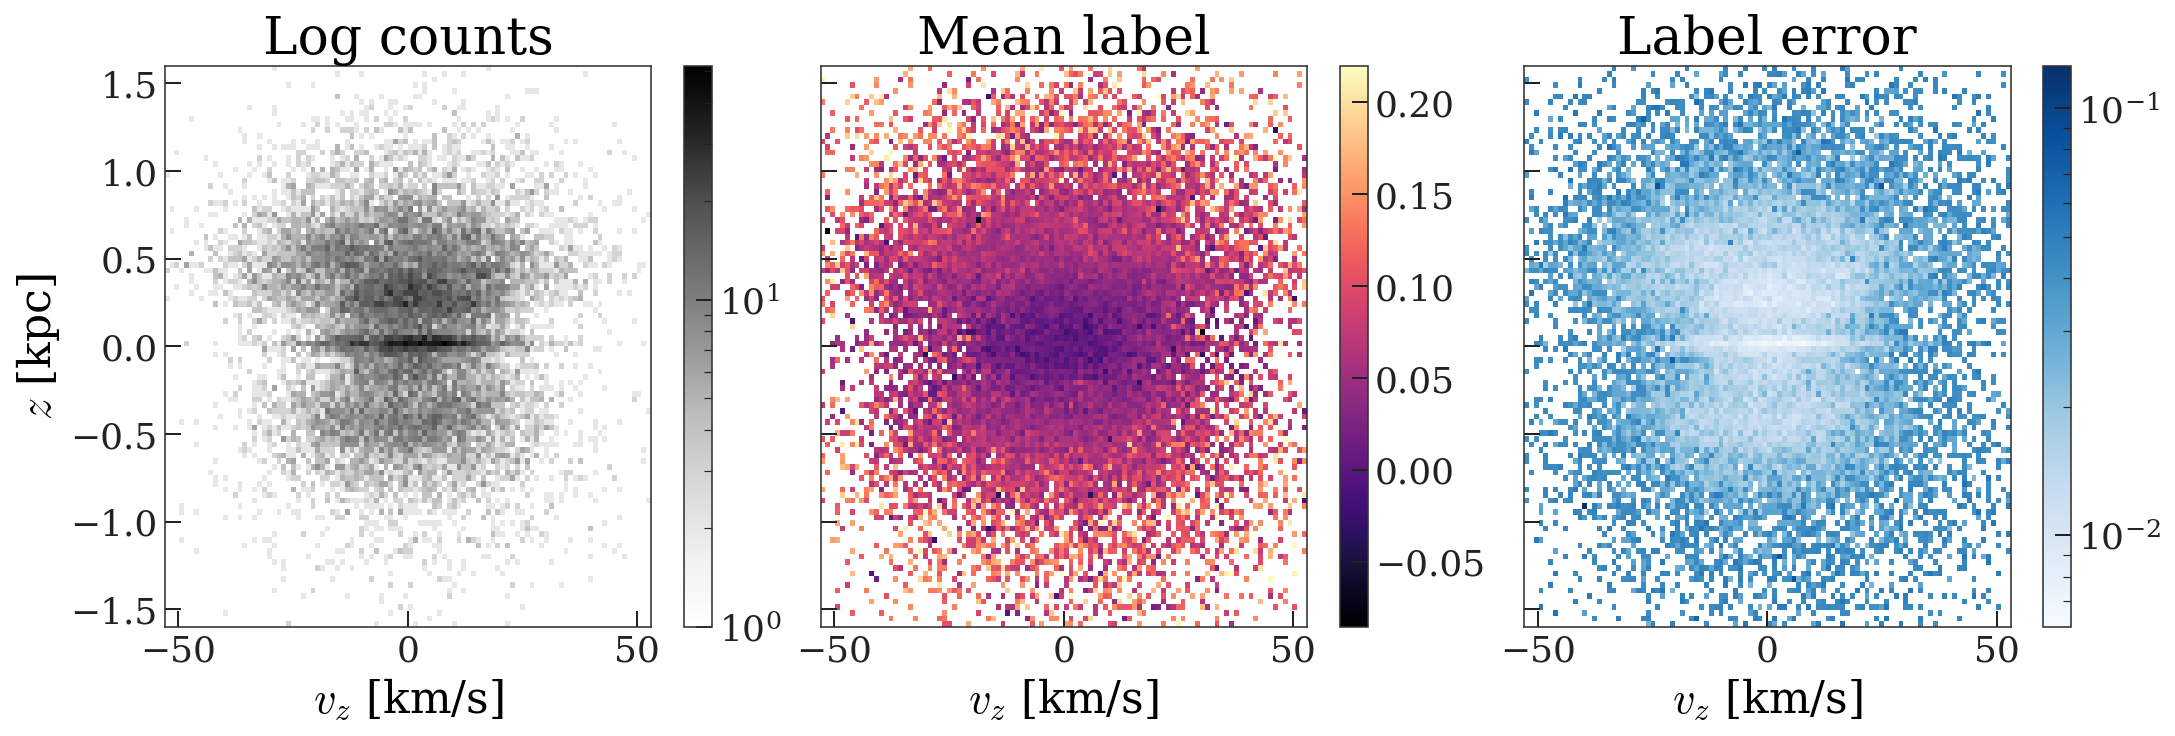

In [190]:
_ = plot_bdata(bdata)

In [191]:
model, bounds, init_params = oti.TorusImaging1DSpline.auto_init(
    bdata,
    label_knots=4,
    e_knots={0: 4, 2: 8, 4: 4},
    label_l2_sigma=1.0,
    label_smooth_sigma=0.5,
    e_l2_sigmas={0: 1.0, 2: 1.0, 4: 1.0},
    e_smooth_sigmas={0: 0.2, 2: 0.2, 4: 0.2},
    dacc_strength=0,
    label_knots_spacing_power=0.75,
    e_knots_spacing_power=0.5,
)

init_params["e_params"][2]["vals"] = np.full_like(
    init_params["e_params"][2]["vals"], -0.25
)
init_params["e_params"][4]["vals"] = np.full_like(
    init_params["e_params"][4]["vals"], np.log(0.1 / model._label_knots.max())
)

In [192]:
data_kw = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=4 * bdata["label_err"],
)
mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
data_kw = {k: v[mask] for k, v in data_kw.items()}

In [193]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **data_kw)

In [194]:
res.state.success, res.state.iter_num, res.state.fun_val

(True, 330, Array(0.03694375, dtype=float64, weak_type=True))

In [195]:
res.params

{'e_params': {0: {'vals': Array([-16., -16., -16.], dtype=float64)},
  2: {'vals': Array([-0.76832935, -0.76854318, -0.770152  , -0.77403742, -0.78290956,
          -0.79586891, -0.79636274], dtype=float64)},
  4: {'vals': Array([-2.03706682, -2.04247832, -2.04099221], dtype=float64)}},
 'label_params': {'label_vals': Array([-0.00523142,  0.47447208,  0.37259946,  0.32690995], dtype=float64)},
 'ln_Omega0': Array(-2.69434679, dtype=float64),
 'pos0': Array(0.03688768, dtype=float64),
 'vel0': Array(0.00026426, dtype=float64)}

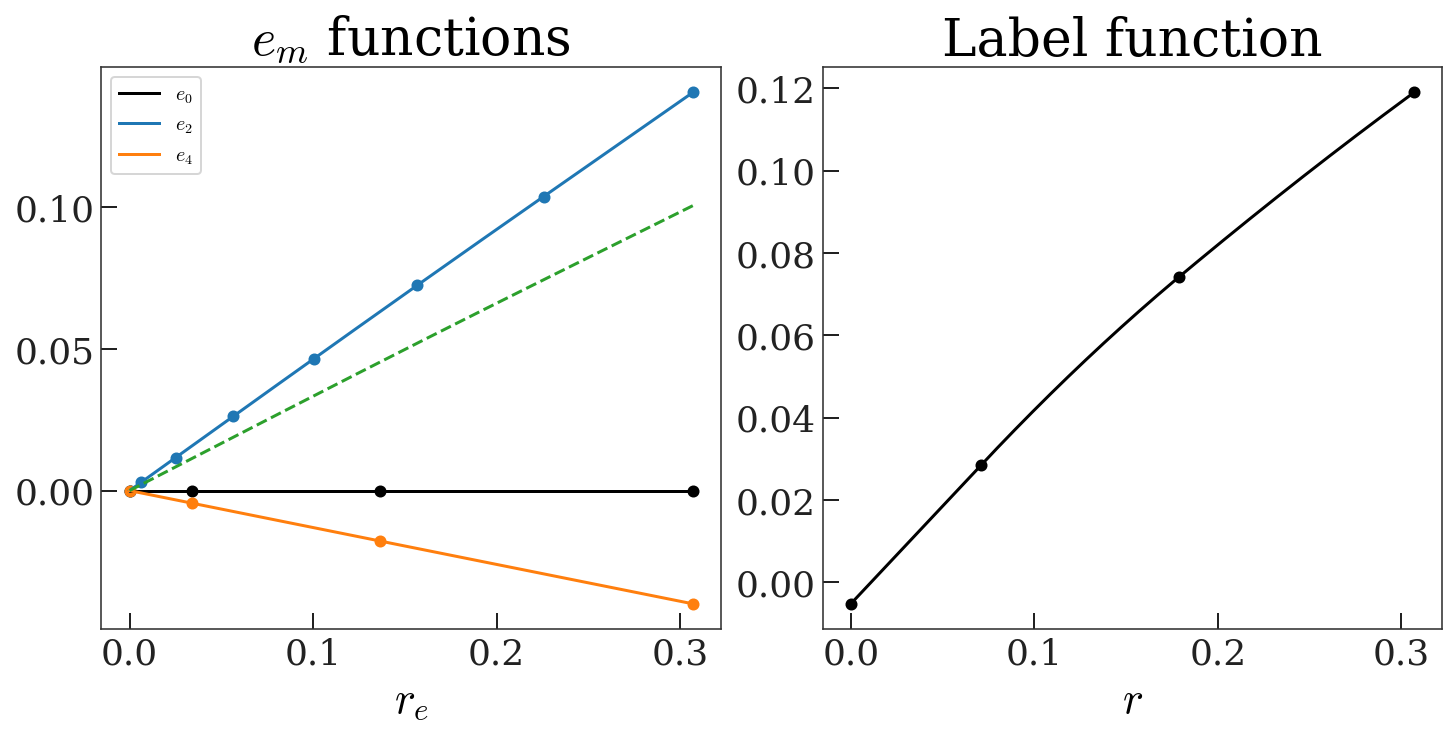

In [196]:
_ = plot_spline_functions(model, res.params)

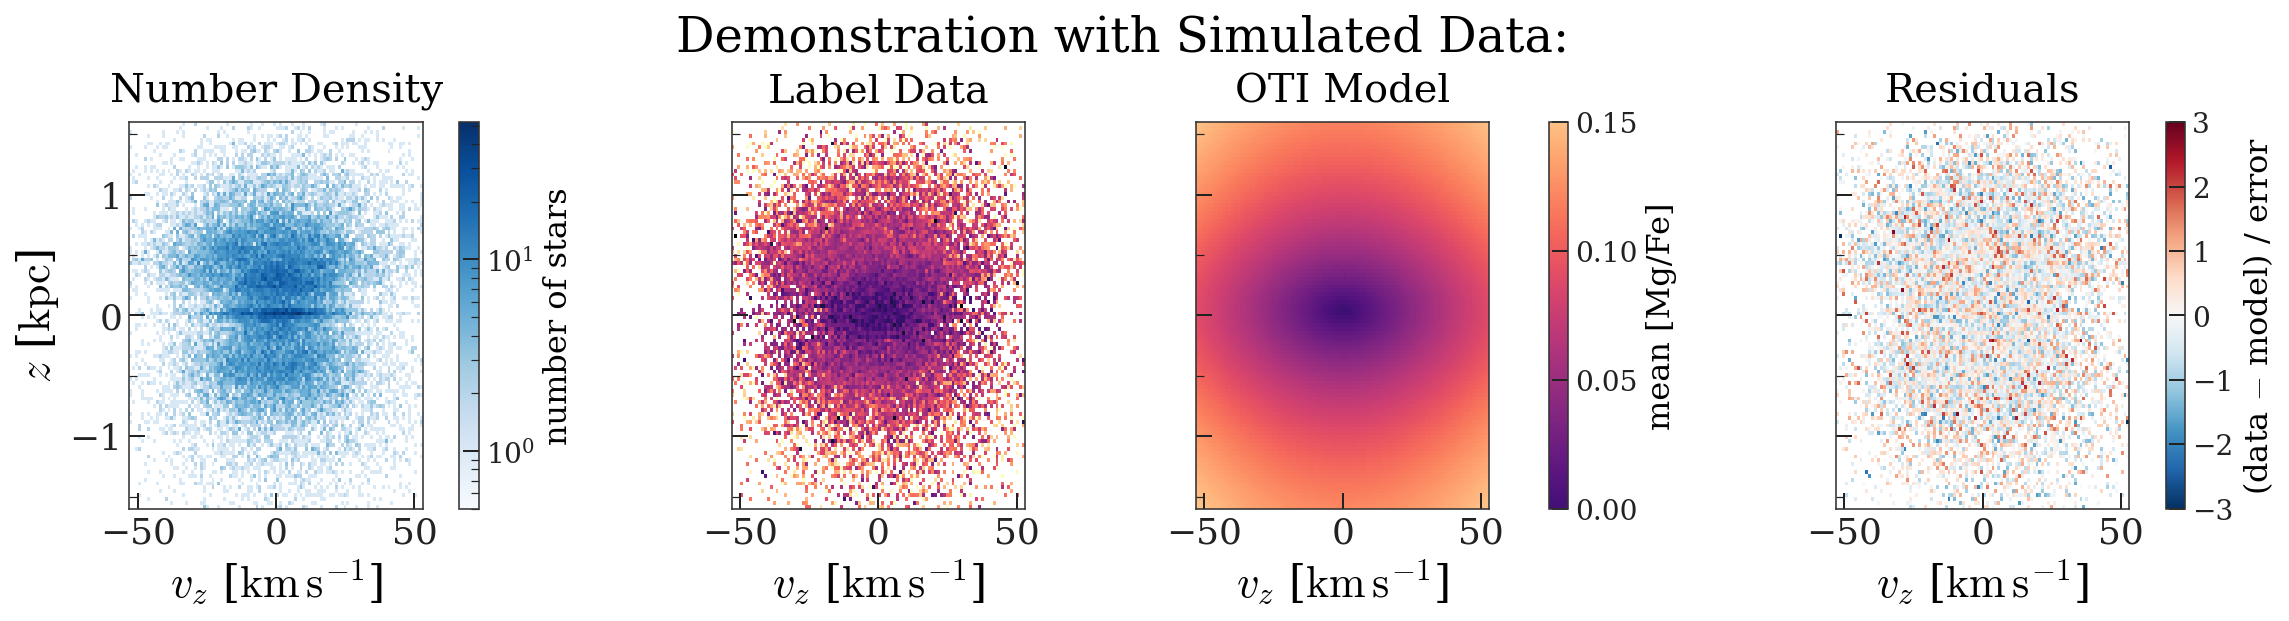

In [197]:
_ = plot_data_model_residual(model, bdata, res.params, zlim=max_z, vzlim=max_vz)

In [198]:
a_unit = u.km / u.s / u.Myr
zgrid = np.linspace(-1, 1, 512) * max_z
bestfit_acc = model.get_acceleration(zgrid, res.params).to(a_unit)

In [199]:
xyz_grid = np.zeros((3, zgrid.size)) * u.kpc
xyz_grid[0, :] = R0
xyz_grid[2] = zgrid

gala_acc = gp.MilkyWayPotential2022().acceleration(xyz_grid).to(a_unit)[2]

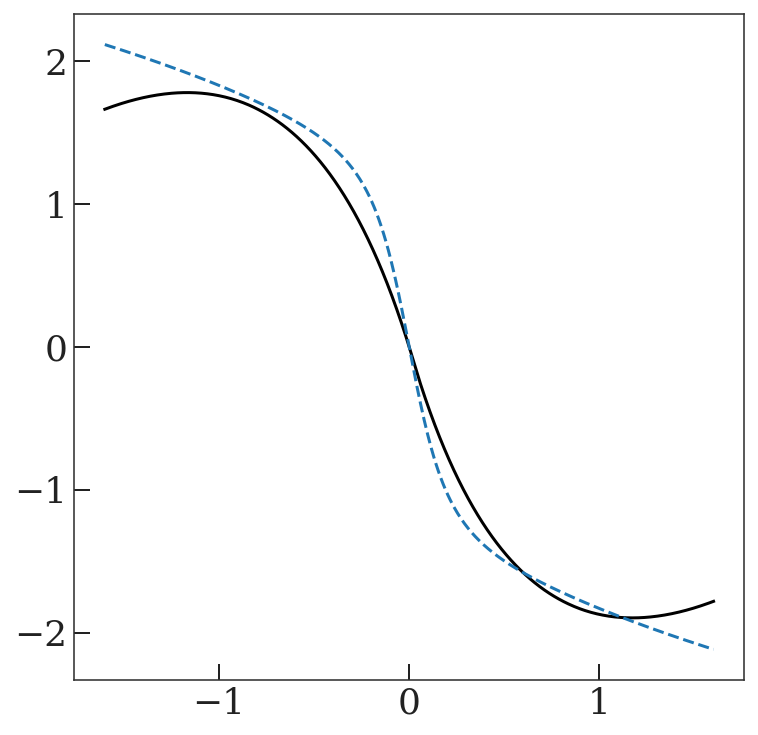

In [200]:
plt.plot(zgrid, bestfit_acc, marker="", ls="-", color="k", label="Best-fit")
plt.plot(zgrid, gala_acc, marker="", ls="--", color="tab:blue", label="Gala")

In [201]:
(np.exp(res.params["ln_Omega0"]) ** 2 / u.Myr**2 / (4 * np.pi * G)).to(
    u.Msun / u.pc**3
)

<Quantity 0.08080576 solMass / pc3>

In [202]:
zs = [1.1] * u.kpc - res.params["pos0"] * u.kpc
Sigma = model.get_acceleration(zs, res.params).to(a_unit) / (2 * np.pi * G)
Sigma = np.abs(Sigma.to(u.Msun / u.pc**2))
Sigma

<Quantity [68.27402765] solMass / pc2>

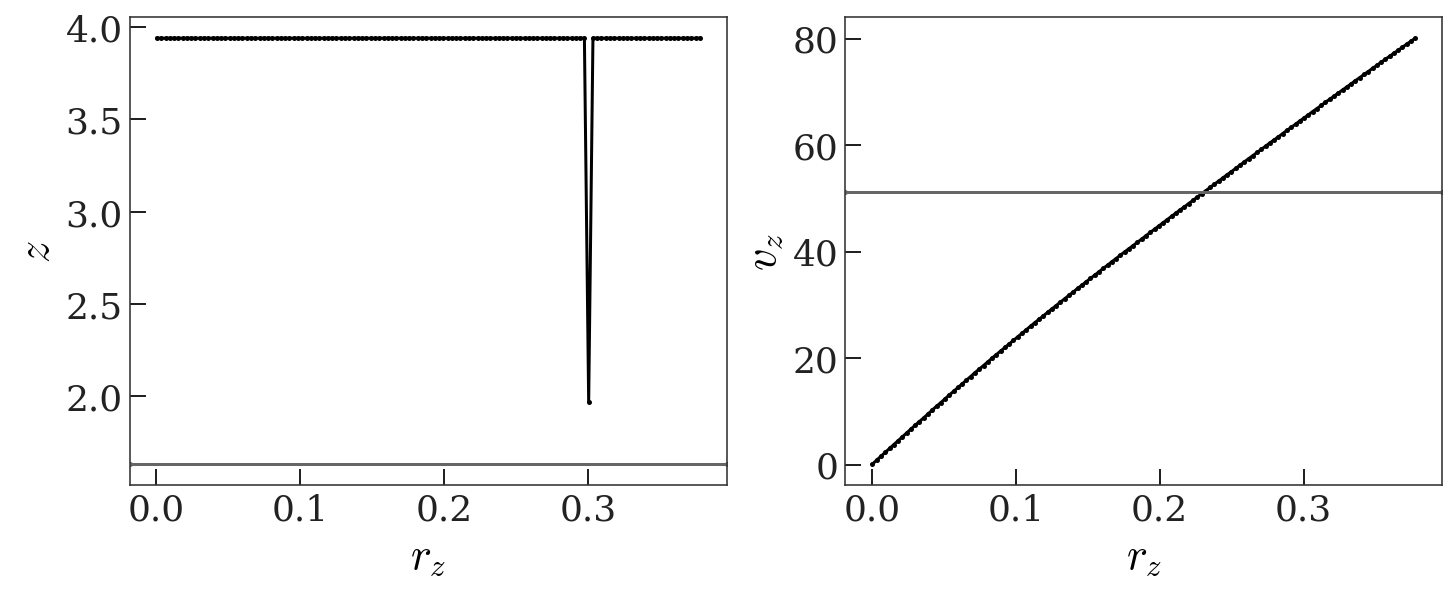

In [17]:
r_grid = np.linspace(1e-3, 1.0, 128) * max_re.value
shit = np.array([model.label_model.get_pos(rr, np.pi / 2, res.params) for rr in r_grid])
fuck = np.array([model.label_model.get_vel(rr, 0.0, res.params) for rr in r_grid])

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4), layout="constrained")

ax = axes[0]
ax.plot(r_grid, shit)
ax.axhline(max_z.value)
ax.set_ylabel("$z$")

ax = axes[1]
ax.plot(r_grid, (fuck * u.kpc / u.Myr).to_value(u.km / u.s))
ax.axhline(max_vz.to_value(u.km / u.s))
ax.set_ylabel("$v_z$")

for ax in axes:
    ax.set_xlabel("$r_z$")

In [18]:
r_e, _ = model.label_model.get_elliptical_coords(
    bdata["pos"].ravel(), bdata["vel"].ravel(), res.params
)
r_e.max()

Array(0.4686383, dtype=float64)

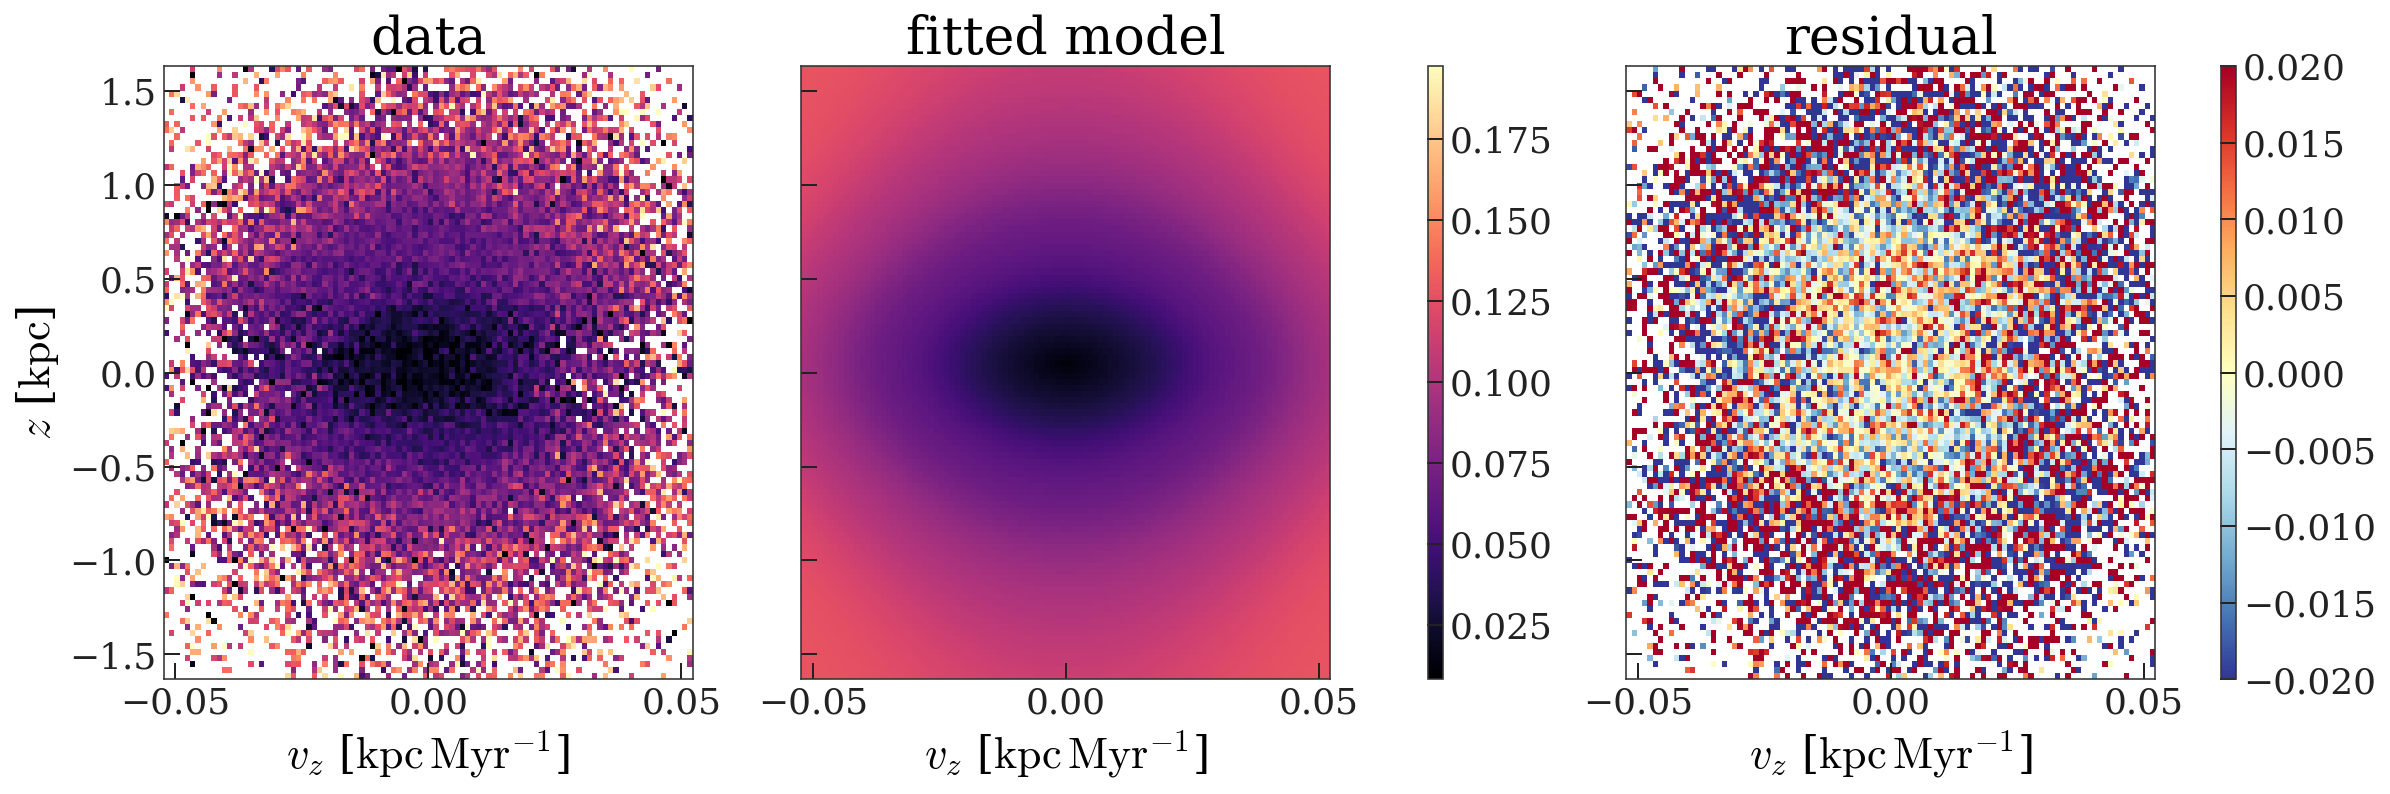

In [19]:
fig, axes = oti.plot.plot_data_models_residual(
    bdata,
    model.label_model,
    res.params,
    label_name="mgfe",
    fractional_residual=False,
    vlim_residual=0.02,
)

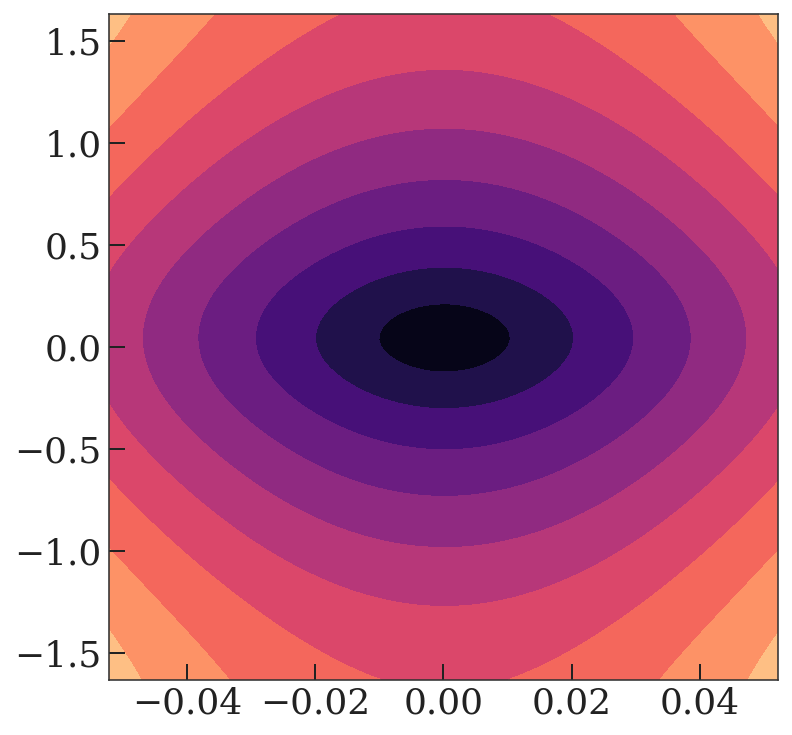

In [20]:
pp, vv = np.meshgrid(
    zvz_bins["pos"].decompose(galactic).value, zvz_bins["vel"].decompose(galactic).value
)
r_e, th_e = model.label_model.get_elliptical_coords(pp, vv, res.params)
r = model.label_model.get_r(r_e, th_e, res.params["e_params"])

plt.contourf(vv, pp, r, levels=np.linspace(0, 1.2 * max_re.value, 12))

In [21]:
model.label_model.check_e_funcs(res.params["e_params"], r_e_max=max_re.value)

(True,
 array([[ 0.0008248 ,  0.00082479,  0.00082475, ..., -0.00134245,
         -0.0013444 , -0.00134505],
        [ 0.0040973 ,  0.00409723,  0.00409703, ..., -0.00666878,
         -0.00667846, -0.00668169],
        [ 0.00986068,  0.00986052,  0.00986002, ..., -0.01604927,
         -0.01607258, -0.01608035],
        ...,
        [ 0.27540062,  0.27538353,  0.2753321 , ..., -0.42100072,
         -0.42158905, -0.42178526],
        [ 0.32343062,  0.32340964,  0.3233465 , ..., -0.49244052,
         -0.4931269 , -0.49335581],
        [ 0.39045976,  0.39043015,  0.39034112, ..., -0.58520978,
         -0.58601706, -0.58628628]]))

In [22]:
Omega = np.exp(res.params["ln_Omega0"]) * u.rad / u.Myr

In [23]:
a_unit = u.km / u.s / u.Myr
zgrid = np.linspace(-1, 1, 512) * z95

Error samples:

In [24]:
tmp_data = bdata.copy()
tmp_data["label"] = tmp_data.pop("mgfe")
tmp_data["label_err"] = tmp_data.pop("mgfe_err")
tmp_mask = np.logical_and.reduce([np.isfinite(tmp_data[k]) for k in tmp_data])
tmp_data = {k: tmp_data[k][tmp_mask] for k in tmp_data}

errs = model.label_model.error_propagate_uncertainty(res.params, tmp_data)
errs

{'e_params': {2: {'vals': Array([0.40708489, 0.30454633, 0.23265945, 0.20450406, 0.23102442,
          0.27211202, 0.38765929], dtype=float64)},
  4: {'vals': Array([0.28737892, 0.4048915 , 0.55695095], dtype=float64)}},
 'label_params': {'label_vals': Array([0.00094022, 0.0187697 , 0.02023578, 0.02224426, 0.02694604,
         0.03537273, 0.06408002, 0.11310592, 0.30313315], dtype=float64)},
 'ln_Omega0': Array([0.04229652], dtype=float64),
 'pos0': Array([0.00277966], dtype=float64),
 'vel0': Array([0.00017094], dtype=float64)}

In [25]:
# M = model.label_model.get_crlb(res.params, tmp_data)  # , inv=True)

# plt.figure(figsize=(6, 5))
# plt.imshow(M, norm=mpl.colors.SymLogNorm(1e-8, vmin=-1e0, vmax=1e0), cmap="RdBu")
# plt.colorbar()

In [26]:
par_samples = model.label_model.get_crlb_error_samples(res.params, tmp_data, size=1024)

In [27]:
res_vals, treedef = jax.tree_util.tree_flatten(res.params)

clean_par_samples = []
for p in par_samples:
    tmp, _ = jax.tree_util.tree_flatten(p)

    tmp_flat = []
    for v, res_v in zip(tmp, res_vals):
        v = np.atleast_1d(v).copy()
        res_v = np.atleast_1d(res_v)
        v[~np.isfinite(v)] = res_v[~np.isfinite(v)]
        v = np.squeeze(v)
        tmp_flat.append(v)
    p = jax.tree_util.tree_unflatten(treedef, tmp_flat)
    clean_par_samples.append(p)

In [28]:
oti_accs = []
# for p in par_samples:
for p in tqdm(clean_par_samples):
    acc = model.label_model.get_acceleration(zgrid, p)
    oti_accs.append(acc.value)
oti_accs = oti_accs * acc.unit

100%|██████████| 1024/1024 [00:05<00:00, 189.20it/s]


Bootstrap trials:

In [32]:
rng = np.random.default_rng(seed=8675309)
trials = []
for trial in trange(8):
    trial_idx = rng.choice(len(oti_data), size=len(oti_data), replace=True)
    _, trial_res = model.run(
        oti_data[trial_idx],
        bins=zvz_bins,
        jaxopt_kw=dict(maxiter=4096, tol=1e-8),
        p0=res.params,
    )
    trials.append(trial_res)

100%|██████████| 8/8 [01:11<00:00,  8.92s/it]


In [33]:
bootstrap_accs = []
for trial_res in trials:
    acc = model.label_model.get_acceleration(zgrid, trial_res.params)
    bootstrap_accs.append(acc.value)
bootstrap_accs = bootstrap_accs * acc.unit

Total err:

In [41]:
xyz_grid = np.zeros((3, zgrid.size)) * u.kpc
xyz_grid[0] = 1.1 * R0
xyz_grid[2] = zgrid
true_acc = gala_pot.acceleration(xyz_grid)

In [42]:
err_prop_err = np.diff(
    np.nanpercentile(oti_accs.T, [16, 84], axis=1).to_value(a_unit), axis=0
)[0]
bootstrap_err = np.std(bootstrap_accs.to_value(a_unit), axis=0)
total_acc_err = np.sqrt(err_prop_err**2 + bootstrap_err**2) * a_unit
# total_acc_err = bootstrap_err * a_unit
# total_acc_err = err_prop_err * a_unit

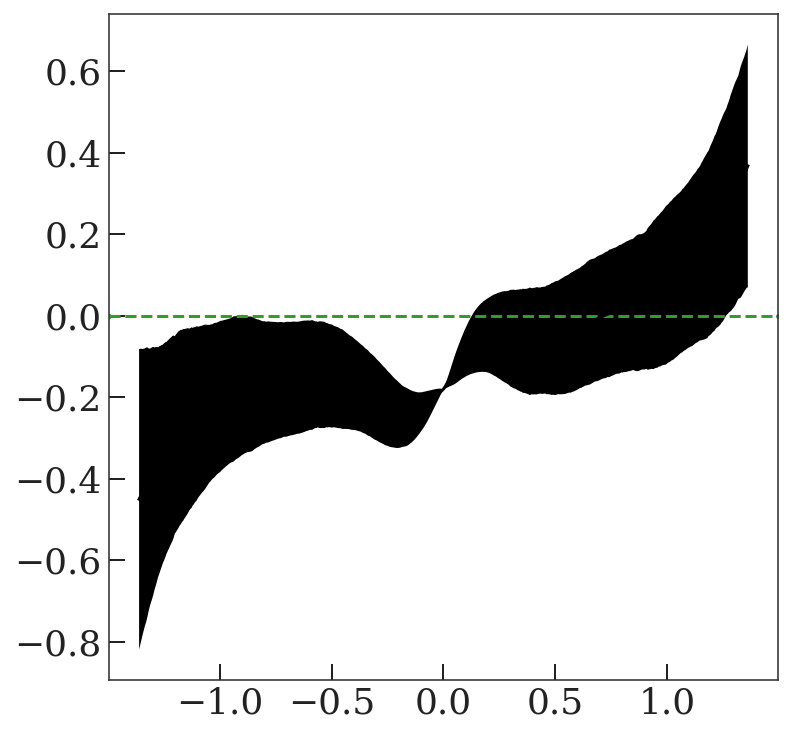

In [43]:
tmp = res.params.copy()
# tmp['pos0'] = 0.
bestfit_acc = model.label_model.get_acceleration(
    zgrid + res.params["pos0"] * u.kpc, tmp
)

dacc = (bestfit_acc - true_acc[2]).to_value(a_unit)

plt.axhline(0.0, ls="--", color="tab:green")
plt.plot(zgrid.value, dacc, marker="", color="k")
plt.fill_between(
    zgrid.value,
    dacc - total_acc_err.to_value(a_unit),
    dacc + total_acc_err.to_value(a_unit),
)
# plt.fill_between(
#     zgrid.value,
#     (np.nanpercentile(oti_accs.T, 16, axis=1) - true_acc[2]).to_value(a_unit),
#     (np.nanpercentile(oti_accs.T, 84, axis=1) - true_acc[2]).to_value(a_unit),
# )
# plt.ylim(-0.1, 0.1)

In [44]:
# bestfit_acc = model.label_model.get_acceleration(zgrid, res.params)

# dacc = ((bestfit_acc - true_acc[2]) / true_acc[2]).decompose().value

# plt.plot(zgrid.value, dacc, marker="", ls="--", color="tab:green")

# colors = ['tab:blue', 'tab:orange', 'tab:red']
# for i, (m, knots) in enumerate(model.e_knots.items()):
#     for k in knots:
#         rr = model.label_model.get_r(k, np.pi/2, res.params['e_params'])
#         zz = model.label_model.get_pos(rr, np.pi/2, res.params)

#         plt.axvline(zz, color=colors[i])
#         plt.axvline(-zz, color=colors[i])

In [38]:
model_mgfe = np.array(model.label_model.label(bdata["pos"], bdata["vel"], res.params))

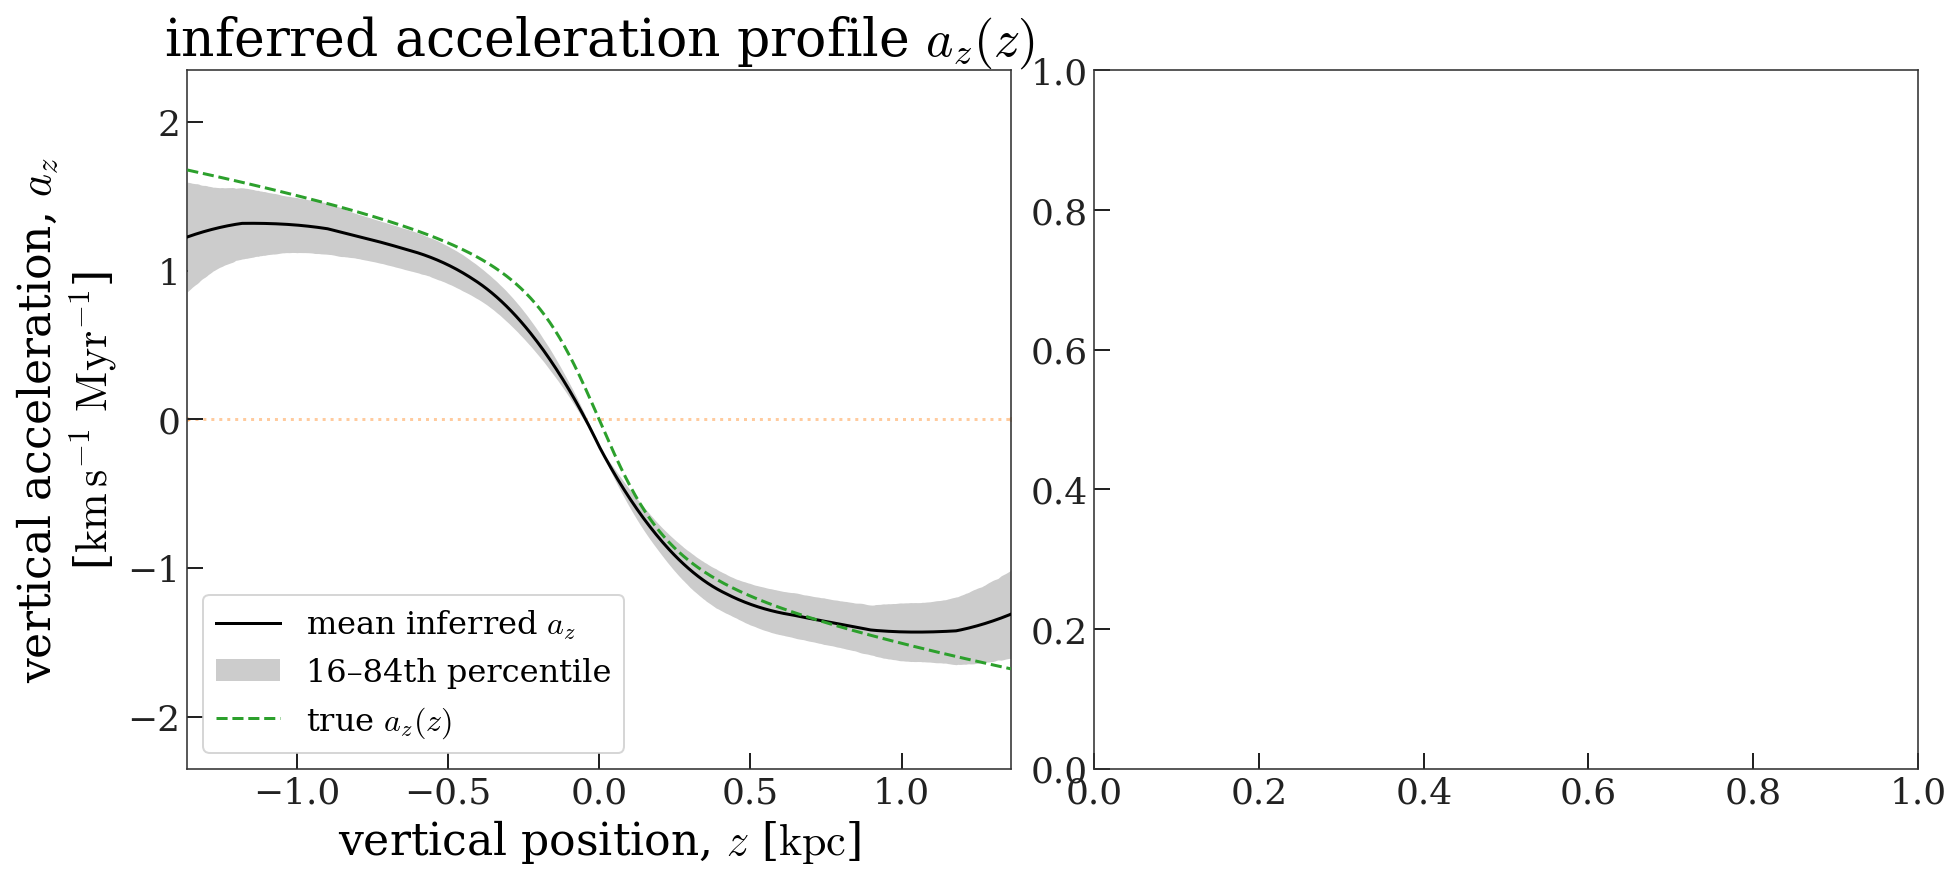

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(13.5, 6.0), layout="constrained")

ax = axes[0]
ax.plot(
    zgrid.value,
    bestfit_acc.to_value(a_unit),
    # np.nanmean(oti_accs.T, axis=1).to_value(a_unit),
    color="k",
    marker="",
    label="mean inferred $a_z$",
    zorder=10,
)
ax.fill_between(
    zgrid.value,
    # np.nanpercentile(oti_accs.T, 16, axis=1).value,
    # np.nanpercentile(oti_accs.T, 84, axis=1).value,
    (bestfit_acc - total_acc_err).to_value(a_unit),
    (bestfit_acc + total_acc_err).to_value(a_unit),
    color="#cccccc",
    lw=0,
    label=r"16–84th percentile",
    zorder=2,
)
ax.plot(
    zgrid.value,
    true_acc[2].to_value(a_unit),
    ls="--",
    color="tab:green",
    marker="",
    label=r"true $a_z(z)$",
    zorder=15,
)
ax.set_xlim(zgrid.value.min(), zgrid.value.max())
ax.set_ylim(
    1.4 * true_acc[2].min().to_value(a_unit), 1.4 * true_acc[2].max().to_value(a_unit)
)
ax.axhline(0, zorder=-10, color="tab:orange", alpha=0.4, ls=":")
ax.legend(loc="lower left", fontsize=16)

ax.set_xlabel(f"vertical position, $z$ [{u.kpc:latex}]")
ax.set_ylabel(
    f"vertical acceleration, $a_z$\n[{u.km/u.s:latex_inline} {u.Myr**-1:latex_inline}]"
)
ax.set_title("inferred acceleration profile $a_z(z)$")

ax = axes[1]
# ax.plot(
#     aaf["J"].to_value(Junit),
#     pdata["J"].to_value(Junit)[aaf_idx, 2],
#     marker="o",
#     ls="none",
#     alpha=0.25,
#     mew=0,
#     ms=2.0,
#     label="particle $J_z$ values",
#     rasterized=True,
# )
# ax.axline(
#     [0, 0],
#     [
#         pdata["J"].to_value(Junit)[aaf_idx, 2].max(),
#         pdata["J"].to_value(Junit)[aaf_idx, 2].max(),
#     ],
#     ls="--",
#     color="tab:green",
#     marker="",
#     label="one-to-one line",
# )
# ax.set_xlim(0, pdata["J"].to_value(Junit)[idx, 2].max())
# ax.set_ylim(0, pdata["J"].to_value(Junit)[idx, 2].max())
# ax.set_title("inferred vertical actions $J_z$")

# ax.legend(loc="lower right", fontsize=16)

# ax.set_xlabel(f"inferred $J_z$ [{Junit:latex_inline}]")
# ax.set_ylabel(f"true $J_z$ [{Junit:latex_inline}]")
# ax.set_xticks(np.arange(0, 200, 50))
# ax.set_yticks(np.arange(0, 200, 50))

# fig.savefig("../tex/figures/qiso-validation.pdf", dpi=250)

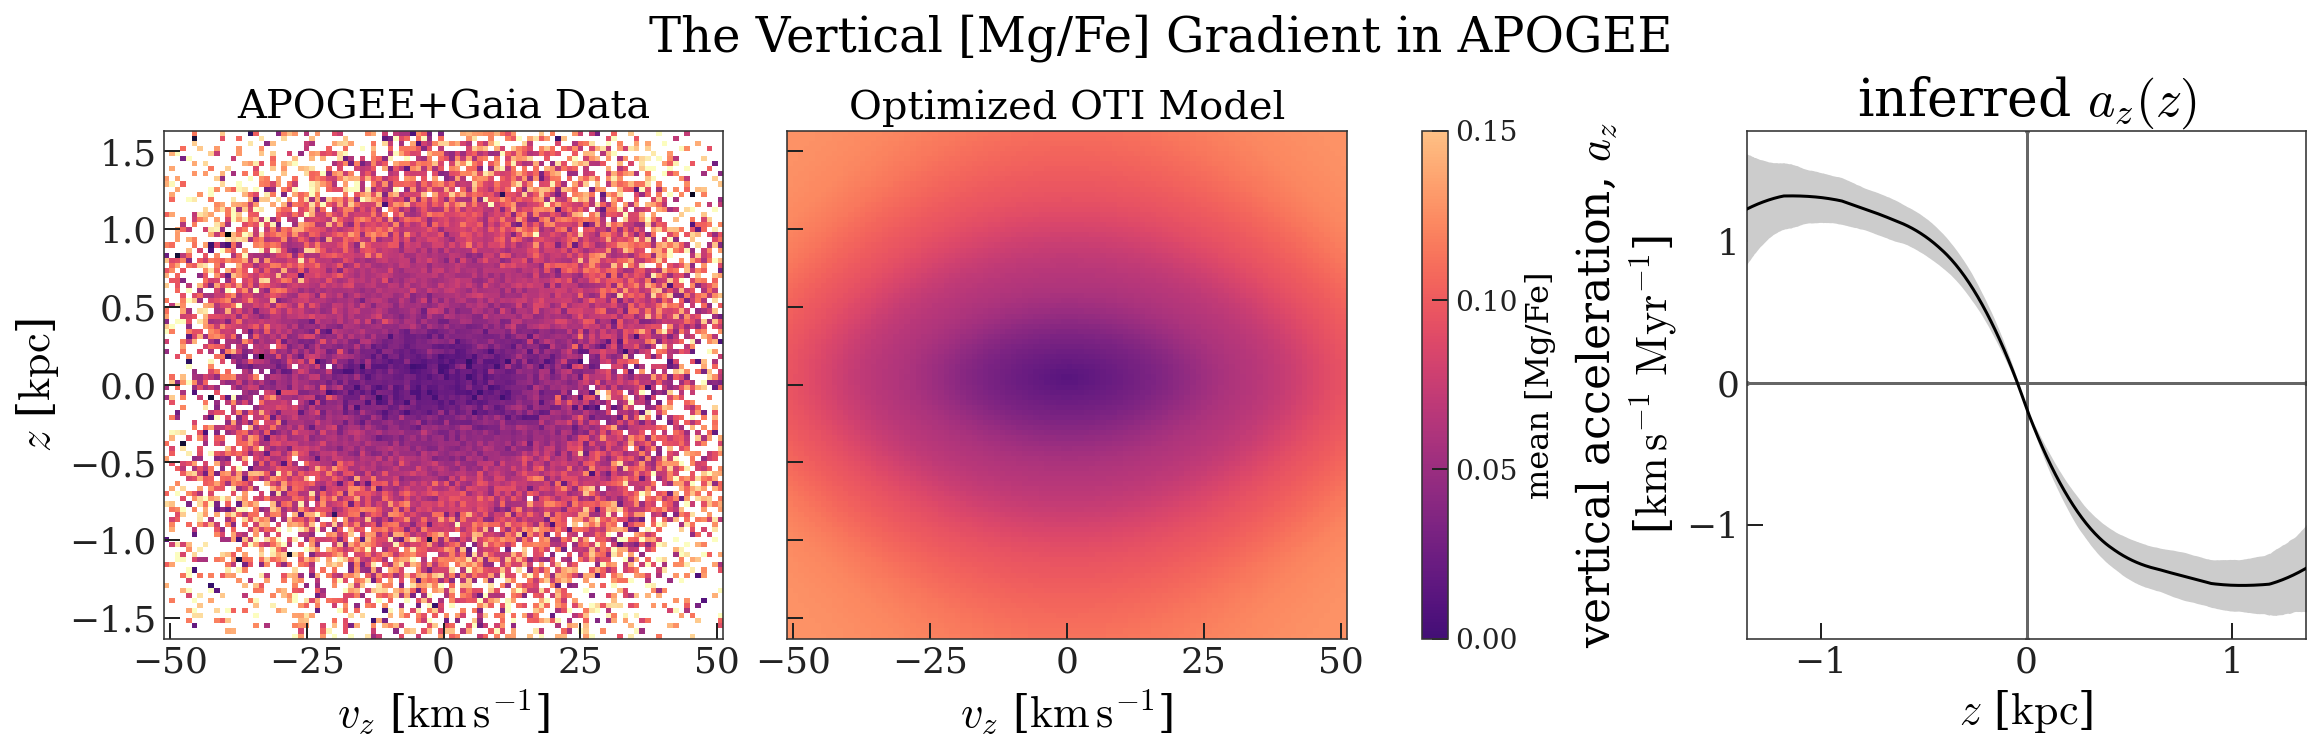

In [173]:
cb_labelsize = 16

fig, axes = plt.subplots(1, 3, figsize=(16, 5.1), layout="constrained")

cs = axes[0].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    bdata["mgfe"],
    #     convolve(bdata["mgfe"], Gaussian2DKernel(2.)),
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
cb = fig.colorbar(cs, ax=axes[0:2])  # , orientation="horizontal", aspect=40)
cb.set_label("mean [Mg/Fe]", fontsize=cb_labelsize)
cb.ax.set_ylim(mgfe_cbar_xlim)
cb.ax.set_yticks(np.arange(mgfe_cbar_xlim[0], mgfe_cbar_xlim[1] + 1e-3, 0.05))
cb.ax.yaxis.set_tick_params(labelsize=14)


cs = axes[1].pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    model_mgfe,
    cmap="magma",
    rasterized=True,
    vmin=mgfe_cbar_vlim[0],
    vmax=mgfe_cbar_vlim[1],
)
# cb = fig.colorbar(cs, ax=axes[1], orientation="horizontal")
# cb.set_label("number density", fontsize=cb_labelsize)


ax = axes[2]
ax.plot(
    zgrid.value,  # + res.params['pos0'],
    bestfit_acc.to_value(a_unit),
    # np.nanmean(oti_accs.T, axis=1).to_value(a_unit),
    color="k",
    marker="",
    label="mean inferred $a_z$",
    zorder=10,
)
ax.fill_between(
    zgrid.value,  # + res.params['pos0'],
    # np.nanpercentile(oti_accs.T, 16, axis=1).value,
    # np.nanpercentile(oti_accs.T, 84, axis=1).value,
    (bestfit_acc - total_acc_err).to_value(a_unit),
    (bestfit_acc + total_acc_err).to_value(a_unit),
    color="#cccccc",
    lw=0,
    label=r"16–84th percentile",
    zorder=2,
)
ax.set_ylabel(
    f"vertical acceleration, $a_z$\n[{u.km/u.s:latex_inline} {u.Myr**-1:latex_inline}]"
)
ax.set_xlim(-z95.value, z95.value)

# Titles
axes[0].set_title("APOGEE+Gaia Data", fontsize=20)
axes[1].set_title("Optimized OTI Model", fontsize=20)
axes[2].set_title("inferred $a_z(z)$")

fig.suptitle("The Vertical [Mg/Fe] Gradient in APOGEE", fontsize=24)

# Labels
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")
for ax in axes[:-1]:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")
axes[2].set_xlabel(f"$z$ [{u.kpc:latex_inline}]")

# Ticks
for ax in axes[:2]:
    ax.set_xticks(np.arange(-50, 50 + 1, 25))
    ax.set_yticks(np.arange(-1.5, 1.5 + 1e-3, 0.5))
axes[1].set_yticklabels(["" for _ in axes[1].get_yticklabels()])

axes[2].axvline(0)
axes[2].axhline(0)

# fig.savefig(
#     "../tex/figures/apogee-gaia-fit.pdf", dpi=250, pad_inches=0.1, bbox_inches="tight"
# )